In [284]:
import pandas as pd
import numpy as np

# OBJECTIF

On se place dans le cas de figure où on veut construire un portefeuille à partir de 4 actifs : 
- Google
- Apple
- Gold
- Exxon

Comment répartir notre portefeuille entre ces 4 actifs ? <br>
Nous choisissons d'optimiser le Sharpe ratio sur une période donnée. <br>
Le but est de se familiariser avec la manipulation de données financières, le Sharpe ratio et de relancer un peu la machine.

# IMPORTATION DES DONNEES
Les csv sont obtenus depuis Yahoo Finance.

In [285]:
def get_data_frame(TICKER):
    '''
    Returns a pd.Series w/ dates from 1/1/2010 to 12/31/2014 as index and Close price 
    for stock 'TICKER' as lone column
    '''
    
    path = "/Users/edouardcuny/Downloads/" + TICKER + ".csv"
    df = pd.read_csv(path)
    df = df.set_index('Date')
    dates = pd.DataFrame(index=pd.date_range(start="1/1/2010", end="12/31/2010"))
    df = dates.join(df)
    df = df['Close']
    df = df.rename(TICKER)
    return df
    

In [297]:
xom = get_data_frame('XOM')
aapl = get_data_frame('AAPL')
goog = get_data_frame('GOOGL')
gld = get_data_frame('GLD')
spy = get_data_frame('SPY')

## COMPLETION DES DONNES
Il n'y a que 252 jours (en moyenne) de trading par an, il faut donc compléter les jours manquants. <br>

Est-ce toutefois bien nécessaire ? La réponse est à examiner pour plus tard (cela change-t-il grand chose si je ne change rien?).

In [298]:
df = pd.concat([xom,aapl,goog,gld], axis=1)
df = df.fillna(method='ffill')
df = df.fillna(method='backfill')

In [299]:
df.head(10)

,XOM,AAPL,GOOGL,GLD
2010-01-01,69.150002,30.572857,311.349976,109.800003
2010-01-02,69.150002,30.572857,311.349976,109.800003
2010-01-03,69.150002,30.572857,311.349976,109.800003
2010-01-04,69.150002,30.572857,311.349976,109.800003
2010-01-05,69.419998,30.625713,309.978882,109.699997
2010-01-06,70.019997,30.138571,302.164703,111.510002
2010-01-07,69.800003,30.082857,295.130463,110.820000
2010-01-08,69.519997,30.282858,299.064880,111.370003
2010-01-09,69.519997,30.282858,299.064880,111.370003
2010-01-10,69.519997,30.282858,299.064880,111.370003


# EVOLUTION D'UN PORTFOLIO

In [300]:
# PORTFOLIO
allocation = [0.25, 0.25, 0.25, 0.25]
funds = 1000

def portfolio_evolution(allocation,funds,df):
    df_2 = df.apply(lambda x: x/x[0]) # normalisation
    df_2 = df_2*allocation
    df_2 = df_2*funds
    df_2['TOTAL']=df_2.sum(axis=1)
    return df_2

print portfolio_evolution(allocation,funds,df).head(10)

                   XOM        AAPL       GOOGL         GLD        TOTAL
2010-01-01  250.000000  250.000000  250.000000  250.000000  1000.000000
2010-01-02  250.000000  250.000000  250.000000  250.000000  1000.000000
2010-01-03  250.000000  250.000000  250.000000  250.000000  1000.000000
2010-01-04  250.000000  250.000000  250.000000  250.000000  1000.000000
2010-01-05  250.976124  250.432213  248.899073  249.772300  1000.079711
2010-01-06  253.145318  246.448762  242.624640  253.893440   996.112160
2010-01-07  252.349967  245.993178  236.976462  252.322397   987.642005
2010-01-08  251.337654  247.628624  240.135622  253.574681   992.676580
2010-01-09  251.337654  247.628624  240.135622  253.574681   992.676580
2010-01-10  251.337654  247.628624  240.135622  253.574681   992.676580


# SHARPE

In [301]:
def sharpe(alloc,df):
    '''
    Returns the Sharpe ratio of an allocation
    alloc is a list 
    '''
    #print df.head(5)

    df_2 = df.apply(lambda x: x/x[0]) # normalisation
    #print df_2.head(5)
    
    df_2 = df_2*alloc
    #print df_2.head(5)
    
    df_2['TOTAL']=df_2.sum(axis=1)
    #print df_2.head(5)
    
    daily_returns = (df_2['TOTAL']/df_2['TOTAL'].shift(1)-1)*100
    daily_returns[0]=0
    
    return np.sqrt(252)*daily_returns.mean()/daily_returns.std(ddof=0)    

In [302]:
def test_sharpe():
    X = pd.DataFrame([1,2])
    daily_returns_X = [0,100]
    if sharpe([1],X) == np.sqrt(252)*np.mean(daily_returns_X)/np.std(daily_returns_X):
        print "all is good"
    else:
        print "sharpe : ", sharpe([1],X)
        print "theoretical sharpe : ", np.sqrt(252)*np.mean(daily_returns_X)/np.std(daily_returns_X)
    
    

In [303]:
test_sharpe()

all is good


# SPY
On compare nos stratégies de portfolio par rapport à l'ETF SPY buy & hold.

In [304]:
spy = spy.fillna(method='ffill')
spy = spy.fillna(method='backfill')
spy_2 = spy/spy[0] # normalisation
spy_2 = spy_2*funds

# OPTIMISATION DU PORTEFEUILLE 

In [305]:
from scipy.optimize import minimize
minimize(lambda x: -sharpe(x,df), [0.25,0.25,0.25,0.25], 
         bounds=[(0,1),(0,1),(0,1),(0,1)], 
         constraints={'type':'eq', 'fun': lambda x: sum(x)-1})

     fun: -1.635007580613583
     jac: array([  5.34074947e-01,   1.58028305e-03,   1.32719313e+00,
        -1.14428997e-03])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  0.00000000e+00,   4.19223246e-01,   3.49682000e-16,
         5.80776754e-01])

In [306]:
print sharpe([0.25,0.25,0.25,0.25],df)
print sharpe([0,0,0.5,0.5],df)
print sharpe([0.1,0.2,0.5,0.2],df)
print sharpe([0,0.4,0,0.6],df)

0.962983518343
0.55247244161
0.628979639526
1.63423727199


On retrouve bien les résultats du cours sur Udacity !

# PLOT DES COURBES

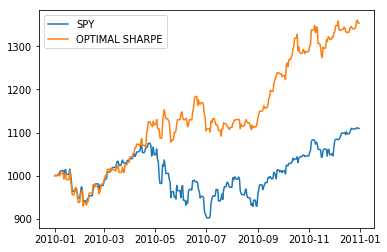

In [314]:
import matplotlib.pyplot as plt
spy_portfolio_ts = portfolio_evolution([1],1000,pd.DataFrame(spy))
sharpe_optim_portolio_ts = portfolio_evolution([0,0.4,0,0.6],1000,df)
plt.close()
plt.plot(spy_portfolio_ts['TOTAL'], label='SPY')
plt.plot(sharpe_optim_portolio_ts['TOTAL'], label='OPTIMAL SHARPE')
plt.legend()
plt.show()

## NEXT STEPS
- essayer en se fichant des jours de trade ou pas 
- regarder comment la stratégie évolue au delà de l'année 2010 sur laquelle on a entraîné notre modèle (validation)